In [91]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as SparseLDA 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform

from scipy.stats import loguniform, beta

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn import set_config

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

from sklearn.svm import SVC

warnings.filterwarnings('ignore')
set_config(display="diagram")

This dataset includes a lot of information about people and their salary, the aim of the project is to predict if a person will earn more or less than 50.000$

I decided to reduce my dataset from 32.000 rows to 10.000 rows since the learning curve showed that after 10.000 rows it's almost useless to continue with the computations.
I also decided to eliminate the rows with no "occupation" value since it's too hard to impute the value of the "occupation" because it depends from the workclass.

In [92]:
income_ds = pd.read_csv('data/income.csv')
income_ds = income_ds.dropna(axis=0, subset=['occupation'])
income_ds = income_ds.iloc[:10000]
income_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10617
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10000 non-null  int64 
 1   workclass       9999 non-null   object
 2   fnlwgt          10000 non-null  int64 
 3   education       10000 non-null  object
 4   education-num   10000 non-null  int64 
 5   marital-status  10000 non-null  object
 6   occupation      10000 non-null  object
 7   relationship    10000 non-null  object
 8   race            10000 non-null  object
 9   sex             10000 non-null  object
 10  capital-gain    10000 non-null  int64 
 11  capital-loss    10000 non-null  int64 
 12  hours-per-week  10000 non-null  int64 
 13  native-country  9819 non-null   object
 14  probabilities   10000 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.2+ MB


In [93]:
y = income_ds.pop('probabilities')

In [94]:
X = income_ds
y = y.map({'<=50K':0,'>50K':1})
y

0        0
1        0
2        0
3        0
4        0
        ..
10613    1
10614    0
10615    0
10616    1
10617    0
Name: probabilities, Length: 10000, dtype: int64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=101)

<AxesSubplot:>

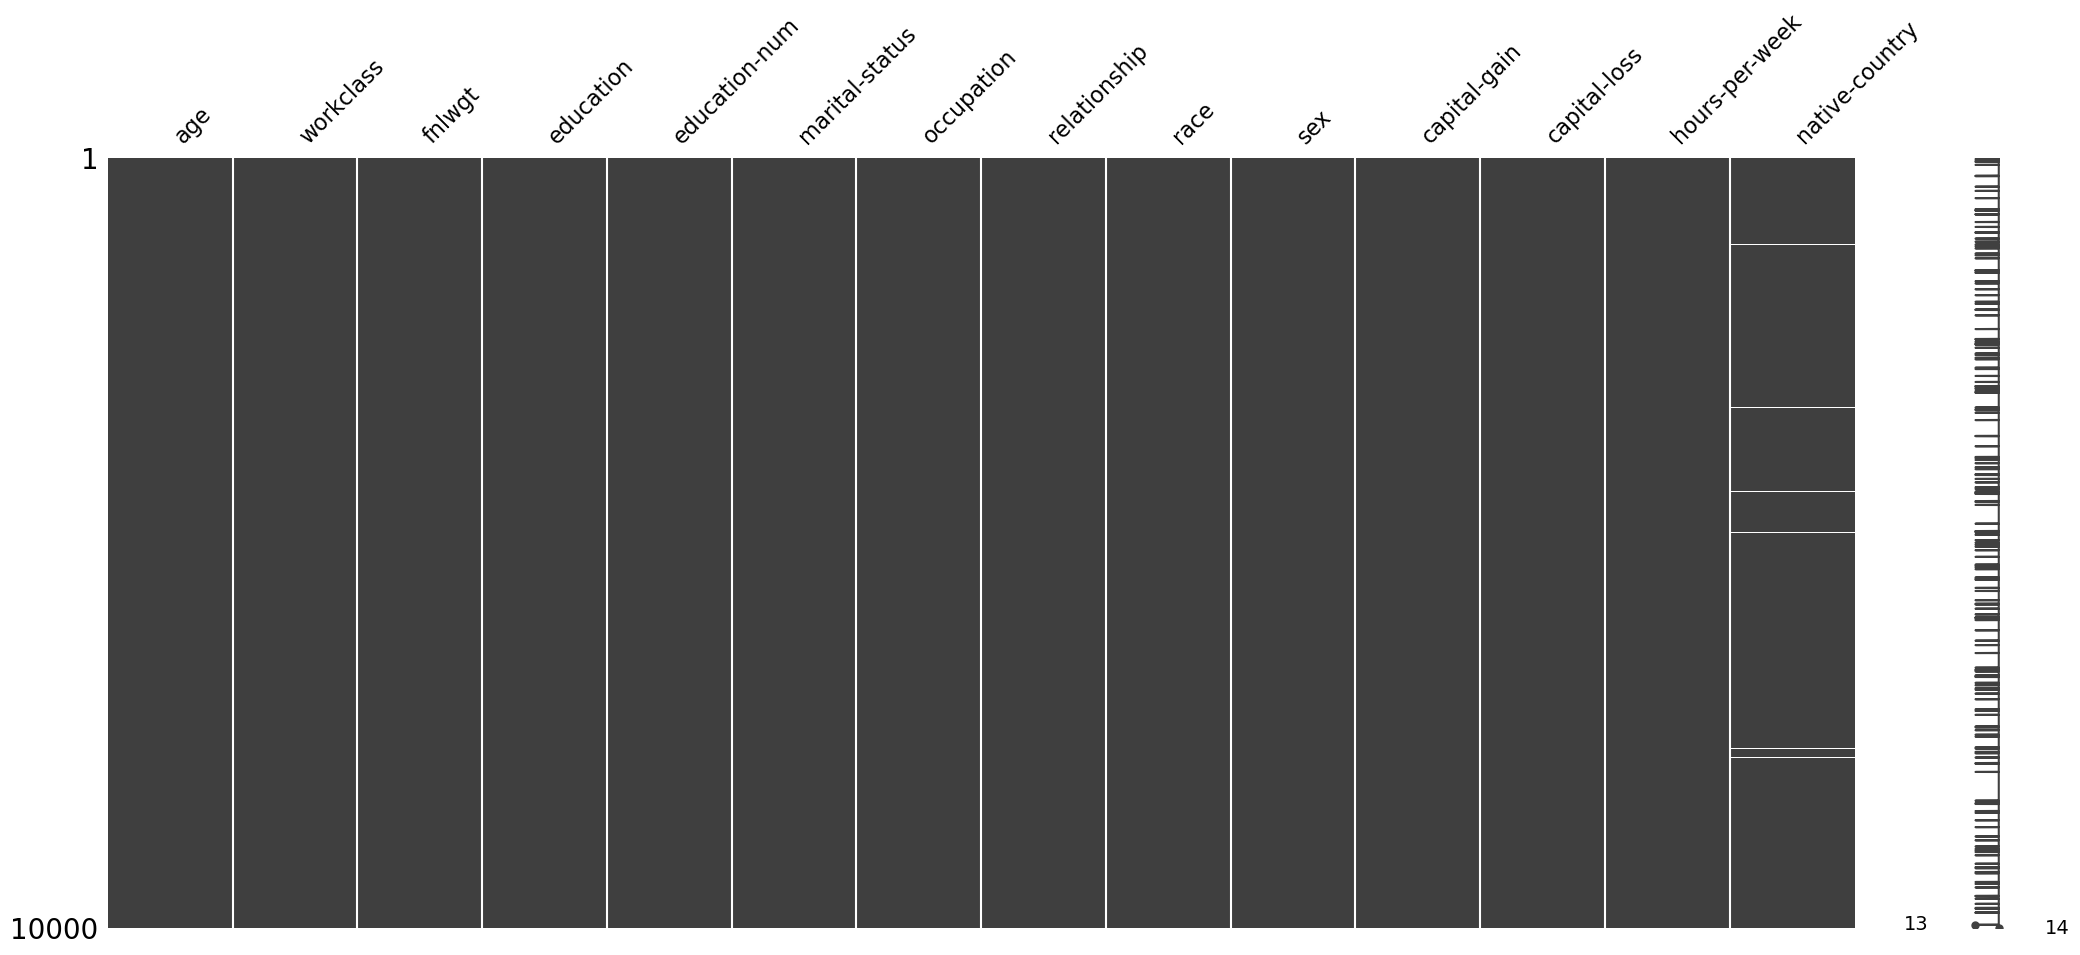

In [96]:
msno.matrix(X)

In [97]:
X.isnull().sum(axis=0)/X.shape[0]

age               0.0000
workclass         0.0001
fnlwgt            0.0000
education         0.0000
education-num     0.0000
marital-status    0.0000
occupation        0.0000
relationship      0.0000
race              0.0000
sex               0.0000
capital-gain      0.0000
capital-loss      0.0000
hours-per-week    0.0000
native-country    0.0181
dtype: float64

In [98]:
X["workclass"].value_counts()

Private             7380
Self-emp-not-inc     856
Local-gov            672
State-gov            430
Self-emp-inc         368
Federal-gov          291
Without-pay            2
Name: workclass, dtype: int64

I decided to use the OneHotEncoder instead of the OrdinalEncoder since the OrdinalEncoder when testing if it founds a new value not mapped it run in error (the handle_unknown='ignore' doesn't work)

In [99]:
age_fnlwgt_cg_cl_hpw_a = Pipeline([
    ('MinMax', MinMaxScaler())
])

workclass_a = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent') ),
    ('hot', OneHotEncoder(categories='auto',drop=None,handle_unknown='ignore'))
])

ms_ed_rl_rc_sex_nc_a = Pipeline([
    ('hot', OneHotEncoder(categories='auto',drop=None,handle_unknown='ignore'))
])

native_country_a = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent') ),
    ('hot', OneHotEncoder(categories='auto',drop=None,handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(transformers=[
    ('age', age_fnlwgt_cg_cl_hpw_a ,['age'] ),
    ('occupation', ms_ed_rl_rc_sex_nc_a ,['occupation'] ),
    ('workclass', workclass_a ,['workclass'] ),
    ('education', ms_ed_rl_rc_sex_nc_a ,['education'] ),
    ('marital-status', ms_ed_rl_rc_sex_nc_a ,['marital-status'] ),
    ('relationship', ms_ed_rl_rc_sex_nc_a ,['relationship'] ),
    ('race', ms_ed_rl_rc_sex_nc_a ,['race'] ),
    ('sex', ms_ed_rl_rc_sex_nc_a ,['sex'] ),
    ('capital-gain', age_fnlwgt_cg_cl_hpw_a ,['capital-gain'] ),
    ('capital-loss', age_fnlwgt_cg_cl_hpw_a ,['capital-loss'] ),
    ('hours-per-week', age_fnlwgt_cg_cl_hpw_a ,['hours-per-week'] ),
    ('native-country', native_country_a ,['native-country'] ),
    ('fnlwgt', 'passthrough', ['fnlwgt'])
],
verbose_feature_names_out=False,
sparse_threshold=0,
n_jobs = -1,
remainder = 'drop'
)

I decided to mantain all the columns of the OneHotEncoder since in the test data I can encounter new value for the feature that must be mapped with all zeros, so I need all the columns.

I tried to use the sparse matrix since I have a lot of 0 given by the OneHotEncoder, but it ended up by increasing the time of execution

I ran the pipeline using a perceptron just to see if it has any error

In [100]:
X_fake = pd.DataFrame(final_transformation.fit_transform(X))
X_fake

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0.301370,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,77516.0
1,0.452055,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,83311.0
2,0.287671,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,215646.0
3,0.493151,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,234721.0
4,0.150685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,338409.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.452055,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,168539.0
9996,0.301370,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,189911.0
9997,0.712329,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,61958.0
9998,0.465753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68898.0


In [101]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.9)),
    ('classifier', Perceptron())
])

In [102]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('MinMax',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('occupation',
                                                  Pipeline(steps=[('hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['occupation']),
                                                 ('workclass',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(handle_unkn...
                                                  Pipeline(steps=[('MinMax',
                                                                   MinMaxScaler())]),
                                                  ['hours-per-week']),
                                                 ('native-country',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native-country']),
                                                 ('fnlwgt', 'passthrough',
                                                  ['fnlwgt'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.9)),
                ('classifier', Perceptron())])

In [103]:
f1_score(y_test, model_pipeline.predict(X_test))

0.29574309185959674

# TESTING MANY CONFIGURATIONS

Here I combine many samplers, dimensionality reduction functions and classifiers to run the cross validation and see what are the best choices

In [104]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy': [0.7, 0.8, 0.9, 1]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy': [0.7, 0.8, 0.9, 1]
    }
]

In [105]:
dim_reduction_configs = [
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.7, 0.8, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), scoring="f1", n_jobs = -1)],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [60, 70, 80]
    }
]

In [106]:
classifier_configs = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 150, 200],
        'classifier__max_depth': [None, 2, 3, 5, 7],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [XGBClassifier(learning_rate = 0.01)],
        'classifier__n_estimators' : [10, 50, 100, 500],
        'classifier__max_depth': [2, 4, 8]
    },
    {
        'classifier': [Perceptron()],
        'classifier__eta0' : loguniform(0.001, 1),
        'classifier__class_weight' : [None, "balanced"]

    },
    {
        'classifier': [LogisticRegression(solver="lib_linear")],
        'classifier__C' : loguniform(0.001, 1),
        'classifier__penalty': ["l1", "l2"],
        'classifier__class_weight' : [None, "balanced"]

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9,11]
    }
]

In [107]:
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) 
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [108]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 45'

In [109]:
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1',
    verbose = 1
)

In [110]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 150 candidates, totalling 300 fits
[CV] END ......................................., score=0.554 total time=   8.5s
Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] END ......................................., score=0.000 total time=   9.1s
Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.7s remaining:    0.0s


[CV] END ......................................., score=0.665 total time=   8.7s
Fitting 2 folds for each of 150 candidates, totalling 300 fits
[CV] END ......................................., score=0.685 total time=   9.9s
Fitting 2 folds for each of 150 candidates, totalling 300 fits
[CV] END ......................................., score=0.658 total time=   9.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.5s finished


In [111]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)
    print(" ")

SMOTE(n_jobs=-1, sampling_strategy=0.9)
LinearDiscriminantAnalysis()
Perceptron(eta0=0.007901038417020362) {'alpha': 0.0001, 'class_weight': None, 'early_stopping': False, 'eta0': 0.007901038417020362, 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.5539452495974235
----------
 
SMOTE(n_jobs=-1, sampling_strategy=0.8)
LinearDiscriminantAnalysis()
Perceptron(class_weight='balanced', eta0=0.13973054859079317) {'alpha': 0.0001, 'class_weight': 'balanced', 'early_stopping': False, 'eta0': 0.13973054859079317, 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.0
----------
 
RandomOverSampler(sampling_strategy=0.7)
LinearDiscriminantAna

In [112]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set: {f1_train}, F1 on test set: {f1_test}, Difference of F1 on train and test set: {f1_train - f1_test}')

F1 on training set: 0.6609571788413099, F1 on test set: 0.6392785571142284, Difference of F1 on train and test set: 0.02167862172708146
F1 on training set: 0.6250215109275512, F1 on test set: 0.6201342281879195, Difference of F1 on train and test set: 0.004887282739631682
F1 on training set: 0.685549900420447, F1 on test set: 0.6614173228346457, Difference of F1 on train and test set: 0.02413257758580123
F1 on training set: 0.6802925989672978, F1 on test set: 0.660472972972973, Difference of F1 on train and test set: 0.01981962599432474
F1 on training set: 0.6709225700164745, F1 on test set: 0.656476267095736, Difference of F1 on train and test set: 0.014446302920738452


# REFINEMENT OF THE SELECTION MODEL

I identified the best configuration (now it's different since I ran it many times and it slightly differs) and I computed it with some hyperparameters similar to the best one above.

In [113]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),

    ("dim_reduction", LDA()),
    ("sampler", RandomOverSampler()),
    ("classifier", XGBClassifier())
])

In [114]:
params = [{
    "classifier__n_estimators": [10, 50, 100, 150, 200],
    "classifier__max_depth": [None, 1, 2, 3, 4, 5],
    "classifier__learning_rate" : uniform(0.0, 0.1)
}]

sampler_params = [{
    "sampler__sampling_strategy": uniform(0.7,0.3)
}]

all_configs = [dict(itertools.chain(*(e.items() for e in configuration)))
for configuration in itertools.product(params,sampler_params)]

In [115]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = all_configs,
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3),
    n_iter=20,
    scoring='f1'
)

In [116]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(n_jobs=-1,
                                                                sparse_threshold=0,
                                                                transformers=[('age',
                                                                               Pipeline(steps=[('MinMax',
                                                                                                MinMaxScaler())]),
                                                                               ['age']),
                                                                              ('occupation',
                                                                               Pipeline(steps=[('hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['occupation']),
                                                                              ('workclas...
                   n_iter=20,
                   param_distributions=[{'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018BCE1F0970>,
                                         'classifier__max_depth': [None, 1, 2,
                                                                   3, 4, 5],
                                         'classifier__n_estimators': [10, 50,
                                                                      100, 150,
                                                                      200],
                                         'sampler__sampling_strategy': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018BCE1F0190>}],
                   scoring='f1')

In [117]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('MinMax',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('occupation',
                                                  Pipeline(steps=[('hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['occupation']),
                                                 ('workclass',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(handle_unkn...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.09247170815341903, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [118]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.6699916874480466

In [119]:
cls = rs_best.best_estimator_

# PLOTS

In [120]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

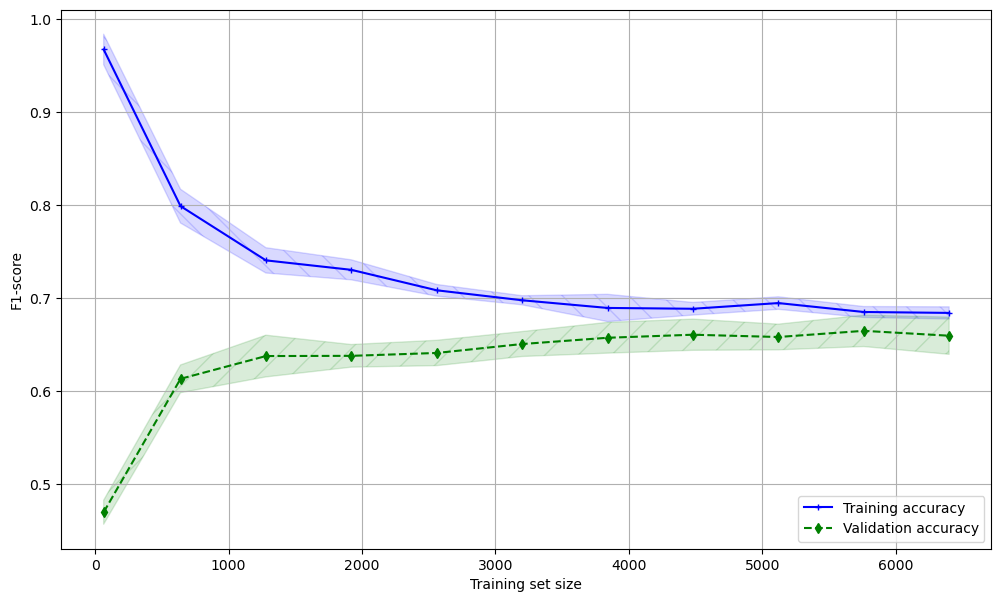

In [121]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axA = fig.add_subplot()

axA.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

axA.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue', 
                 hatch='\\')

axA.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

axA.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axA.grid()
axA.set_xlabel('Training set size')
axA.set_ylabel('F1-score')
axA.legend(loc='lower right')
axA.set_autoscale_on(True)

In [122]:
range_classifier =  [10, 50, 100, 150, 200]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_classifier, 
        param_name='classifier__n_estimators',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

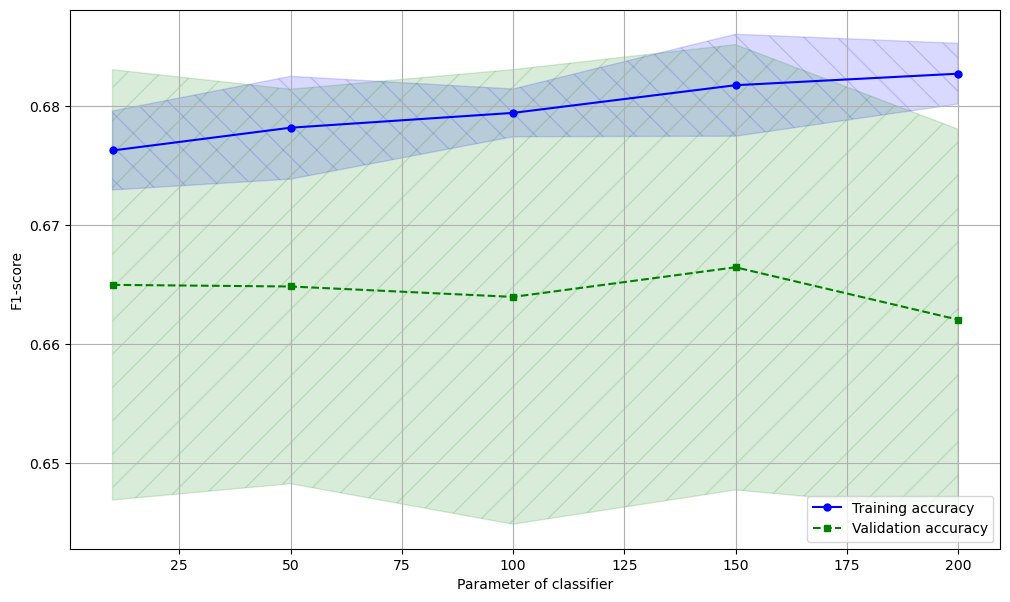

In [123]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axB = fig.add_subplot()
axB.plot(range_classifier, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

axB.fill_between(range_classifier,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue',
                 hatch='\\')

axB.plot(range_classifier, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

axB.fill_between(range_classifier,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axB.grid()
axB.set_xlabel('Parameter of classifier')
axB.set_ylabel('F1-score')
axB.legend(loc='lower right')
axB.set_autoscale_on(True)

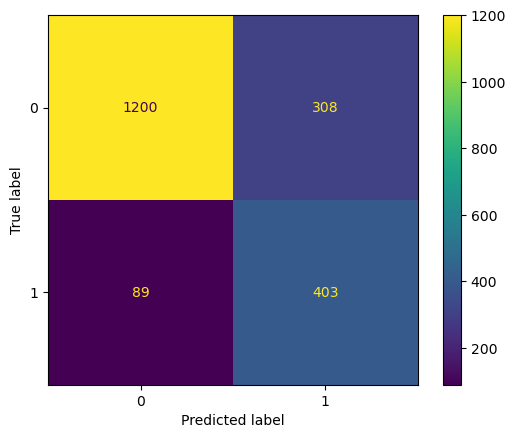

In [124]:
from sklearn.metrics import plot_confusion_matrix
# generare la matrice di confusione
plot_confusion_matrix(rs_best, X_test, y_test)
plt.show()

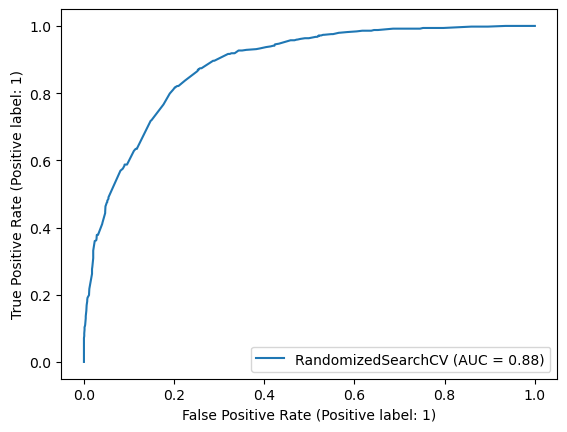

In [125]:
from sklearn.metrics import plot_roc_curve
# generare la curva ROC
plot_roc_curve(rs_best, X_test, y_test)
plt.show()